In [ ]:
!pip install plotly -Uq
!pip install sidetable -Uq

In [1]:
!pip install -U kaleido

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import sidetable

# Project description
So our task is to help optimize marketing expenses.   

**We have:**    
* Server logs with data on Yandex.Afisha visits from June 2017 through May 2018   
* Dump file with all orders for the period   
* Marketing expenses statistics   

**You are going to study:**    
* How people use the product    
* When they start to buy
* How much money each customer brings    
* When they pay off   


Let's divide our work on next steps:

*1. Step 1 - Let's study our data in general, what we should work with and optimize little bit*   
*2. Step 2 - Let's make reports and calculate metrics in terms of sales, marketing and product*   
*3. Step 3 - Let's formulate advice for marketing experts how much money to invest and where in conclusion.*   

### Step 1. Take a look at general information
Ok, we going to proceed to first step and at once from beginning I'll optimize columns in "read_csv" method: 

In [3]:
try:
    visits = pd.read_csv(r"C:\Users\Dell\Documents\tempPy\myProjects\ForGit\Business_Analytics_YaAfisha\visits_log_us.csv", dtype={'Device': 'category'}, parse_dates=['Start Ts', 'End Ts'])
except:
    print('Try another database')

In [ ]:
visits.info(memory_usage='deep')

In [ ]:
visits.sample(10) 

In [ ]:
visits.stb.missing(style = True)

In [4]:
try:
    orders = pd.read_csv(r"C:\Users\Dell\Documents\tempPy\myProjects\ForGit\Business_Analytics_YaAfisha\orders_log_us.csv", parse_dates=['Buy Ts'])
except:
    print('Try another database')

In [ ]:
orders.info(memory_usage='deep')

In [ ]:
orders.sample(10)

In [ ]:
orders.stb.missing(style = True)

In [5]:
try:
    costs = pd.read_csv(r"C:\Users\Dell\Documents\tempPy\myProjects\ForGit\Business_Analytics_YaAfisha\costs_us.csv", parse_dates=['dt'])
except:
    print('Try another database')

In [ ]:
costs.info(memory_usage = 'deep')

In [ ]:
costs.sample(10)

In [ ]:
costs.stb.missing(style = True)

As we see we don't have any missing values, just let's change names of columns (convert to lower case and replace spaces for convenience) and we can proceed to next step

In [6]:
visits.columns = visits.columns.str.lower()
visits.columns = visits.columns.str.replace(' ', '_')
visits

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [7]:
orders.columns = orders.columns.str.lower() 
orders.columns = orders.columns.str.replace(' ', '_')
orders

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [8]:
costs.columns = costs.columns.str.lower()
costs.columns = costs.columns.str.replace(' ', '_')
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


### Step 2. Reports and calculations   
Ok, let's describe what kind of questions we have to discuss

#### **Product**   
 - How many people use it every day, week, and month?   
 - How many sessions are there per day? (One user might have more than one session.)    
 - What is the length of each session?   
 - How often do users come back?   

##### How many people use it every day, week, and month?   
Ok, let's plot graphs for daily/weekly/monthly users activity

In [9]:
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['week'] = visits['start_ts'].astype('datetime64[W]')
visits['date'] = visits['start_ts'].dt.date

In [10]:
dau = visits.groupby('date').agg({'uid':'nunique'}).reset_index()
dau.head()

,date,uid
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


In [11]:
print('Average DAU:', dau['uid'].mean())

Average DAU: 907.9917582417582


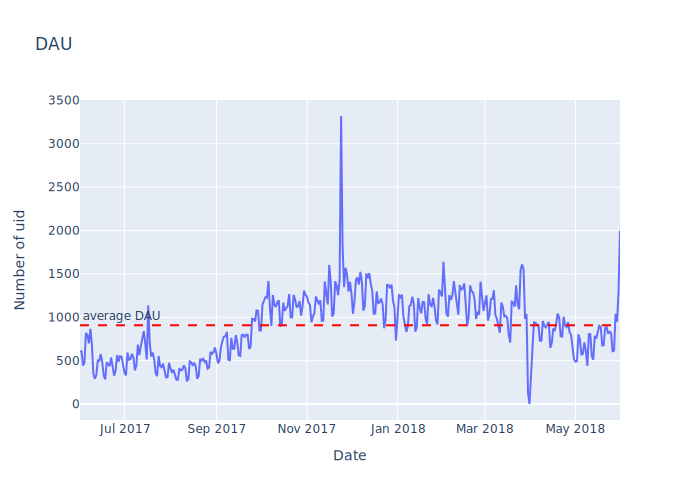

In [14]:
fig = px.line(dau, x = 'date', y = 'uid', title = 'DAU', labels ={'date': 'Date', 'uid': 'Number of uid'})
fig.add_hline(y = dau['uid'].mean(), line_dash = 'dash', line_color = 'red', annotation_text = 'average DAU', 
              annotation_position = 'top left')
fig.show('svg')
fig.write_image("C:/Users/Dell/Documents/tempPy/myProjects/ForGit/Business_Analytics_YaAfisha/DAU1.png")

In [ ]:
wau = visits.groupby('week').agg({'uid':'nunique'}).reset_index()
wau.head()

In [ ]:
print('Average WAU:', wau['uid'].mean())

In [ ]:
fig = px.line(wau, x = 'week', y = 'uid', title = 'WAU', labels ={'week': 'Week', 'uid': 'Number of uid'})
fig.add_hline(y = wau['uid'].mean(), line_dash = 'dash', line_color = 'red', annotation_text = 'average WAU', 
              annotation_position = 'top left')
fig.show()

In [ ]:
mau = visits.groupby('month').agg({'uid':'nunique'}).reset_index()
mau.head()

In [ ]:
print('Average MAU:', mau['uid'].mean())

In [ ]:
fig = px.line(mau, x = 'month', y = 'uid', title = 'MAU', labels ={'month': 'Month', 'uid': 'Number of uid'})
fig.add_hline(y = mau['uid'].mean(), line_dash = 'dash', line_color = 'red', annotation_text = 'average MAU', 
              annotation_position = 'top left')
fig.show()

**Conclusion**    

So, the DAU (daily) graph looks like the cardiogram of healthy person, that tended to increase from August 2017 to January 2018 with an obvious peak on 24th November where 3319 unique users were attracted.  After January 2018 it tended to decrease to the first decade of May with a huge fall on 31st of March, where just 1 new user was attracted and following increasing during May.   

Almost the same picture we can observe on WAU (weekly) and MAU (monthly) graph, where we see increasing from August to November, and following decreasing from end of November to end of May.   

##### How many sessions are there per day? (One user might have more than one session.)

Let's plot two graphs: the first one for number of users per day only and the second one for both tables - sessions per day and daily active users 

In [ ]:
session_per_day = visits.groupby('date').agg({'uid': 'count'}).reset_index()
session_per_day.head() 

In [ ]:
print('Average sessions per day:', session_per_day['uid'].mean())

In [ ]:
fig = px.line(session_per_day, x = 'date', y = 'uid', 
              title = 'Sessions per day', labels ={'date': 'Date', 'uid': 'Number of uid'})
fig.add_hline(y = session_per_day['uid'].mean(), line_dash = 'dash', 
              line_color = 'red', annotation_text = 'Average sessions per day', annotation_position = 'top left')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dau['date'], y=dau['uid'], mode='lines', name='DAU', line = dict(color='yellow', width=2)))

fig.add_trace(go.Scatter(x=session_per_day['date'], y=session_per_day['uid'], mode='lines', 
                         name='sessions',line = dict(color='black', width=2 )))

fig.update_layout(title='Sessions per day compared DAU', xaxis_title='Date', 
                  yaxis_title='Number of uid', showlegend=True, plot_bgcolor="grey")
fig.show()

**Conclusion**   

As we see on both graphs (DAU and sessions per day) it's a pretty same picture: the graphs has the same trend, the number of sessions per day little bit bigger (almost the same) that the number of daily active users, that looks logical, because people are going to buy tickets on the same day then they start session, they don't need to have several sessions to accomplish purchase.   

##### What is the length of each session?   

Here we'll count average session lentgh (ASL)

In [ ]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits.head()

In [ ]:
print(visits['session_duration'].mean())
visits['session_duration'].hist(bins = 50);

We see how distribution is skewed, so let's use mode() function

In [ ]:
asl = visits['session_duration'].mode()
asl

**Conclusion**   

The average session take near 60 second to make purchase

##### How often do users come back?

So, first, let's define users first day of visit

In [ ]:
first_visit = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visit.columns = ['uid','first_visit']
first_visit.head()

And after that let's merge back to visits table

In [ ]:
visits = visits.merge(first_visit, how = 'inner', on = ['uid'])
visits.head()

Now we'll define cohorts and interval between current visit and first visit:  

In [ ]:
visits['cohort'] = visits['first_visit'].astype('datetime64[M]')
visits['age'] = ((pd.to_datetime(visits['date']) - pd.to_datetime(visits['first_visit'])) / 
                 np.timedelta64(1, 'M')).round().astype('int')
visits.head()

Now let's define number of unique visitors for each cohort during whole period:

In [ ]:
visit_cohorts = visits.pivot_table(index = 'cohort', columns = 'age', values = 'uid', aggfunc = 'nunique').fillna(0)
visit_cohorts 

After that we'll define retention rate and plot heatmap

In [ ]:
retention=visit_cohorts.iloc[:,0:].div(visit_cohorts[0], axis=0)
retention

In [ ]:
retention.index=retention.index.astype(str)
plt.figure(figsize=(15, 9))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax = 0.1)
plt.title('Cohorts: User Retention')
plt.show()

**Conclusion**    
 
So, in general, our graphs show us that our customers spend a pretty small amount of time using our product, they have quite a low percentage of returning from the first session and we can mention the peak of user activity from October to March. Everything sounds logical: you don't need a lot of time to view events, you just check info in general. Also, in general, tickets don't have high check, it's situation of "low decision margin" and users don't looking where is lowest price, so they do not need return to our product several times. And the highest level of activity fall in most cold period, where are a lot of events take place. 

#### **Sales**   
 - When do people start buying? (In KPI analysis, we're usually interested in knowing the time that elapses between registration and conversion — when the user becomes a customer. For example, if registration and the first purchase occur on the same day, the user might fall into category Conversion 0d. If the first purchase happens the next day, it will be Conversion 1d. You can use any approach that lets you compare the conversions of different cohorts, so that you can determine which cohort, or marketing channel, is most effective.)   
 - How many orders do they make during a given period of time?   
 - What is the average purchase size?   
 - How much money do they bring? (LTV)   

#####  When do people start buying?

At first, let's define date of first purchase:

In [ ]:
first_order = orders.groupby(['uid'])['buy_ts'].min().reset_index()
first_order.columns = ['uid', 'first_order']
first_order.head() 

Let's join to this table those visitors with the same ID, after we'll calculate the number of days between first purchase and first visit and plot histogram:  

In [ ]:
start_purchase = first_order.merge(visits, how = 'left', on = ['uid'])
start_purchase.head()

**Conclusion**   

Sorry, could you explain what is particularly wrong on that point? If we're talking about calculations, we have to define the number of days between the date of first session and date of first purchase, right? Other words we have to subtract values in the *'first visit'* column from the *'first order'* column... In that case, the *'first visit'* column I've already joined in previous task, when defined the cohorts. I mean that there are no points to duplicates, it's the same values either in **'first_visit'** table or **'visit'** table

In [ ]:
start_purchase['conversion'] = ((pd.to_datetime(start_purchase['first_order'])-pd.to_datetime(start_purchase['first_visit']))
                                / np.timedelta64(1,'D')).astype('int')

In [ ]:
fig = px.histogram(start_purchase, x="conversion", 
                   nbins=100, labels ={'conversion': 'Conversion (days)'}, 
                   title = 'Distribution of conversion from the first purchase to the first visit (in days)')
fig.show()

***After reviewer's comment:***   
Done

As we see, the histogram skewed, so let's define median value:

In [ ]:
start_purchase['conversion'].median()

And the overall conversion by dividing number of unique orders on number of unique visitors: 

In [ ]:
print('The overall conversion is {:.1%}'.format(orders['uid'].nunique()/visits['uid'].nunique()))

**Conclusion**   

So, as we see it doesn't take a lot of time to make a purchase from the moment of first attraction: it takes place or in the same day or on the next one

##### How many orders do they make during a given period of time?

We have to build cohorts for counting number of orders, so let's repeat the similar calculations with visits table: 

In [ ]:
orders['month'] = orders['buy_ts'].astype('datetime64[M]')
orders['week'] = orders['buy_ts'].astype('datetime64[W]')
orders['date'] = orders['buy_ts'].dt.date

In [ ]:
orders = orders.merge(first_order, how = 'inner', on = ['uid'])
orders.head()

Let's define cohorts and number of users that fall in cohorts: 

In [ ]:
orders['cohort'] = orders['first_order'].astype('datetime64[M]')
cohort_size = orders.groupby('cohort').agg({'uid': 'nunique'}).reset_index()
cohort_size.columns = ['cohort', 'cohort_size']
cohort_size.head()

Now, we'll define the number of purchases: 

In [ ]:
order_cohorts = orders.groupby(['cohort', 'month'])['revenue'].count().reset_index()
order_cohorts.columns = ['cohort', 'month', 'num_orders']
order_cohorts.head()

Let's merge two tables, and define the number of purcahses per byuers: 

In [ ]:
order_cohorts = order_cohorts.merge(cohort_size, on = ['cohort'])
order_cohorts['age'] = ((order_cohorts['month'] - order_cohorts['cohort']) / np.timedelta64(1, 'M')).round().astype('int')
order_cohorts['orders_per_buyer'] = order_cohorts['num_orders'] / order_cohorts['cohort_size']
order_cohorts.head() 

In [ ]:
num_orders=order_cohorts.pivot_table(index='cohort', columns='age', values='orders_per_buyer', aggfunc='sum').cumsum(axis=1)
num_orders.round(2).fillna('')

**Conclusion**


So, as we can see, in terms of number purchases per user, the June 2017 cohort users "behave" themself much better than others: from an initial 1.16 purchase per user, they have the highest level of purchases per user in the next months. For instance, the November 2017 cohort users, that have initial 1.18 purchases per user have lower level of purchases from the second month. 

##### What is the average purchase size?

Instead of defining the number of purchases that we've made in the previous task now we'll define the average revenue for each cohort:

In [ ]:
avg_order_cohorts = orders.groupby(['cohort', 'month'])['revenue'].mean().reset_index()
avg_order_cohorts['age'] = ((avg_order_cohorts['month'] - avg_order_cohorts['cohort']) /
                            np.timedelta64(1, 'M')).round().astype('int')
avg_order_cohorts.head()

In [ ]:
avg_order = avg_order_cohorts.pivot_table(index = 'cohort', columns = 'age', values = 'revenue', aggfunc = 'mean')
avg_order.round(2).fillna('')

**Conclusion**

Here we can mention a kind of "explosion" for September cohort, that has "leap" on third month (December) and high level in 4th, 5th and 6th month as well. We can also mention a huge increase for December cohort in 2nd and 3rd months, and high level in 4th and 5th.

But in general, all cohorts have almost the same level of average check that doesn't varied so strongly through their "lifetime"

##### How much money do they bring? (LTV)

Again, like in case we've defined the average number of orders we have to make same steps to define lifetime value (LTV). In first step we'll define the total revenue:  

In [ ]:
ltv_cohorts = orders.groupby(['cohort', 'month'])['revenue'].sum().reset_index()
ltv_cohorts.columns = ['cohort', 'month', 'total_revenue']
ltv_cohorts.head()

Let's merge two tables: total revenue per cohort and number of customers per cohort:

In [ ]:
ltv_cohorts = ltv_cohorts.merge(cohort_size, on = ['cohort'])
ltv_cohorts['age'] = ((ltv_cohorts['month'] - ltv_cohorts['cohort']) / np.timedelta64(1, 'M')).round().astype('int')

In [ ]:
ltv_cohorts['ltv'] = ltv_cohorts['total_revenue'] / ltv_cohorts['cohort_size']
ltv_cohorts.head()

In [ ]:
ltv = ltv_cohorts.pivot_table(index = 'cohort', columns = 'age', values = 'ltv', aggfunc = 'sum').cumsum(axis=1)
ltv.round(2).fillna('')

And we'll plot heatmap: 

In [ ]:
ltv.index = ltv.index.astype(str)
plt.figure(figsize=(15, 12))
sns.heatmap(ltv, annot=True, fmt='.2f', linewidths=1, 
            linecolor='grey', cbar_kws= {'orientation': 'horizontal'}).set(title ='LTV')
plt.show()

**Conclusion**   

Again, in terms of LTV we have September 2017 cohort as a leader, because cumulative sum bigger than even June 2017 cohort that has longer "lifetime": \\$13.44 per user after 8 months for September compared with \\$11.88 per user for June respectively. Also, we can consider July, August and December cohorts successful as well.

***Conclusion for Sales Block:***   

Ok, let's summarize:
It takes just one day to make purchase, and it's kind of fast sale, and it's sound logical - you don't have to spent a lot of time to make purchase ticket for certain event. Also, in most cases it's a spontaneous purchase (often, after social media adv) on the nearest event. Also, we don't see on graphs a huge level of repeat sales, currently we can't say about high level of recurrent payments. In average users have similar check, the ticket's prices don't varied a lot, except couple of months where apparently was purchases for a group visitor (group of collogues, for instance)

#### **Marketing**   
 - How much money was spent? Overall/per source/over time   
 - How much did customer acquisition from each of the sources cost?   
 - How worthwhile where the investments? (ROI)   

##### How much money was spent? Overall/per source/over time

**Overall**

In [ ]:
costs = costs.sort_values(by = ['dt', 'source_id'])
costs.head()

In [ ]:
print('Total marketing cost is {}'.format(costs['costs'].sum()))

**Per source** 

Ok, let's define sum of cost per source and plot the some graphs: 

In [ ]:
costs_per_source = costs.groupby(['source_id'])['costs'].sum().reset_index()
costs_per_source.head()

In [ ]:
fig = px.bar(costs_per_source, x = 'source_id', y = 'costs', 
             labels ={'source_id': 'Type of source', 'costs': 'Sum of costs'}, title = 'Distribution of costs per source')
fig.update_xaxes(type='category')
fig.show()

In [ ]:
fig = px.line(costs, x="dt", y="costs", color='source_id', 
             labels ={'dt': 'Date', 'costs': 'Sum of costs'}, title = 'Distribution of costs per source and days')
fig.show()

**Conclusion**   

The source №3 our leader in terms of overall acquisition cost, more then 140K\\$. After that there are three channels: №№4,5 and 2. Next one №1 with 20K\\$ and №№9 and 10 have the lowest indicators. 

In terms of daily costs, we can mention the next one:   
- sources 9 and 10 are equal   
- source 1 has the same trend with sources 2 and 5, but less significant   
- sources 2 and 5 are almost equal, different in several points   
- source 4 actually seems so similar to source 3, there are a lot of days where costs are equal at the peaks, but so huge different on bottom positions. 

##### How much did customer acquisition from each of the sources cost?

For defining customer acquisition cost (CAC), we have to compute marketing costs for attracting customers that made purchases. First, let's add a new column that equals cohorts in other tables:

In [ ]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
costs.head()

Second, let's define the sum spent on attracting per month:

In [ ]:
costs_by_month = costs.groupby(['cost_month'])['costs'].sum().reset_index()
costs_by_month.columns = ['cost_month', 'costs_in_month']
costs_by_month.head()

In [ ]:
orders.head()

We've already done it, but let's make it again - define the number of customers per month: 

In [ ]:
num_buyers_per_month = orders.groupby(['cohort'])['uid'].nunique().reset_index()
num_buyers_per_month.columns = ['cost_month', 'num_buyers']
num_buyers_per_month.head()

After that we merge two tables and add a new column CAC by dividing the sum of money that has been spent on attracting customers:

In [ ]:
CAC_per_month = costs_by_month.merge(num_buyers_per_month, how = 'left', on = ['cost_month'])
CAC_per_month['CAC'] = CAC_per_month['costs_in_month'] / CAC_per_month['num_buyers']
CAC_per_month.head()

In [ ]:
fig = px.line(CAC_per_month, x="cost_month", y="CAC", title='CAC', labels ={'cost_month': 'Month'})
fig.show()

**Conclusion**   

If we're talking about customer acquisition costs in general, the average cost per customer falls between 7,5\\$ and 11\\$. The most expensive customers were in August and the most cheapest - in May

**CAC per source**

First, we should define the source, from that user came from first time and it will be kind of original source. 

In [ ]:
first_source_visit = visits.sort_values('date').groupby('uid')['source_id'].first().reset_index()
first_source_visit.columns = ['uid', 'first_source']
first_source_visit.head()

After that we'll merge first source to purchase table:

In [ ]:
first_source_order = orders.merge(first_source_visit, how = 'left', on = 'uid')
first_source_order.head()

Now, we'll calculate the sum of customer cost per source and per month

In [ ]:
costs_by_month_source = costs.groupby(['cost_month', 'source_id'])['costs'].sum().reset_index()
costs_by_month_source.head()

After that let's define number of customers per month and per source as well

In [ ]:
byuers_per_month_source = first_source_order.groupby(['cohort', 'first_source'])['uid'].nunique().reset_index()
byuers_per_month_source.columns = ['cost_month', 'source_id', 'num_byuers']
byuers_per_month_source.head()

Now we'll merge two tables and define customer acquisition costs by dividing costs by number of customers and we'll plot graph

In [ ]:
CAC_per_month_source = costs_by_month_source.merge(byuers_per_month_source, how = 'left', on = ['cost_month', 'source_id'])
CAC_per_month_source['CAC'] = CAC_per_month_source['costs'] / CAC_per_month_source['num_byuers']
CAC_per_month_source.head()

In [ ]:
fig = px.line(CAC_per_month_source, x="cost_month", y="CAC", 
              color='source_id', title='CAC per month and per source', labels ={'cost_month': 'Month'})
fig.show()

**Conclusion**    

It turns out that all sources are different and have different trends over different periods. Sources 2 and 3 are most expensive and have similar trend between September and March, source 4 after October become straight, and the rest sources are varied from month to month

##### How worthwhile where the investments? (ROI)

At first, we'll define ROI for cohort. We've already made calculations of CAC and LTV, so let's rewrite names of columns and let's merge two tables, calculate ROI and plot the graphs

In [ ]:
CAC_per_month_ROI = CAC_per_month[['cost_month', 'CAC']]
CAC_per_month_ROI.columns = ['cohort', 'CAC']
ROI = ltv_cohorts.merge(CAC_per_month_ROI, how = 'left', on = ['cohort'])
ROI.head()

In [ ]:
ROI['ROI']=ROI['ltv']/ROI['CAC']
roi_piv = ROI.pivot_table(index='cohort', columns='age', values='ROI', aggfunc='mean').cumsum(axis=1)
roi_piv.round(2).fillna('') 

In [ ]:
roi_piv.index=roi_piv.index.astype(str)
plt.figure(figsize=(15, 12))
sns.heatmap(roi_piv, annot=True, fmt='.2%', linewidths=1, 
            linecolor='grey', cbar_kws= {'orientation': 'horizontal'}).set(title ='ROI per cohort')
plt.show()

**Conclusion**   

We can see the similar picture with LTV per cohort: we can call September, June, July and December most succsessfull cohorts in terms of returns of investments.  

Now, let's define ROI for each source according the same logic:

In [ ]:
ltv_per_source = first_source_order.groupby(['first_source'])['uid', 'revenue'].agg({'uid': 'nunique', 'revenue': 'sum'}).reset_index()
ltv_per_source.columns = ['source_id', 'num_byuers', 'total_revenue']
ltv_per_source['ltv'] = ltv_per_source['total_revenue'] / ltv_per_source['num_byuers']
ltv_per_source.head()

In [ ]:
roi_per_source = costs_per_source.merge(ltv_per_source, on = ['source_id'])
roi_per_source['cac'] = roi_per_source['costs'] / roi_per_source['num_byuers']
roi_per_source['romi'] = roi_per_source['ltv'] / roi_per_source['cac']
roi_per_source.head()

In [ ]:
fig = px.bar(roi_per_source, x='source_id', y='romi', 
             title = 'ROMI per source', labels ={'source_id': 'Source', 'romi': 'ROMI'}, text_auto = '.2')
fig.update_xaxes(type='category')
fig.show()

**Conclusion**   

So, we see that the most worth channel is source 1 - he's a obvious leader with almost x2 gap. The next one sources 2, 5 and 9 are similar and we can say they are succsessfull as well (despite more higher level of CAC for source 2)   
Also I want to mention source 10 - pretty good indicator.   

### Step 3. Overall conclusion

**Conclusion**    

So, after a first look at two graphs I would like recommend to marketing department stop wasting money on source 3. It is obvious spender, as we see in graphs CAC per source - during entire period source 3 is leader in terms of amount money spending on attract protentional buyers. The ROMI graphs says that source 3 - "champion" in terms of inefficiency, the ratio LVT to CAC 0.36 that means for 1\\$ LTV accounts almost 3\\$ of CAC.    
Also, just 3 types of resource show kind of "success": №№ 1, 2 and 5, where the ratio LVT: CAC more than 1. It looks that the current strategy for source 1 is working and a pretty good "quality" of incoming customers is talking about the right direction, and, probably, increasing budgets for this channel may pay off with more benefits. As we see ROMI on a high level, CAC and the budget are one of the lowest.   